### 第五章 手写数字识别器

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


### 定义超参数

In [2]:
image_size = 28
num_classes = 10
batch_size = 64

### 数据准备

In [3]:
import torch.utils.data.sampler

# 数据集
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

# 索引
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 采样器
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_test)

# 加载器
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          sampler=sampler_test)

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
  

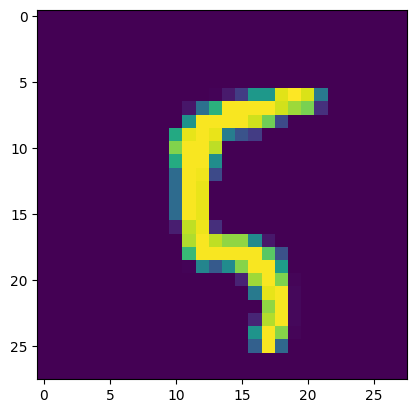

In [4]:
idx = 100

# dataset支持下标索引，每个元素有features和target
muteimg = train_dataset[idx][0].numpy()
print(muteimg)
plt.imshow(muteimg[0,...])
print('标签是：', train_dataset[idx][1])

### 构建网络

In [5]:
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, depth[0], 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding=2)
        # 线性映射层，两次2*2池化，所以长和宽都要除以4
        self.linearInputSize = image_size // 4 * image_size // 4 * depth[1]
        self.fc1 = nn.Linear(self.linearInputSize, 512) 
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        # 卷积泛化部分
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # 全连接部分
        x = x.view(-1, self.linearInputSize)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def retrieve_features(self, x):
        """提取前两层卷积层的特征图"""
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
    

### 运行模型

In [6]:
def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [7]:
net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
record = []
weights = []
num_epochs = 5


for epoch in range(num_epochs):
    train_rights = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.clone().requires_grad_(True), target.clone().detach()
        # 启动训练模式
        net.train()

        #前向传播
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        
        #反向传播
        loss.backward()
        optimizer.step()

        right = rightness(output, target)
        train_rights.append(right)

        if batch_idx % 100 == 0:
            net.eval()
            val_rights = []
            
            for (data, target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output = net(data)
                right = rightness(output, target)
                val_rights.append(right)
            train_r = (sum([tup[0] for tup in train_rights]), sum(tup[1] for tup in train_rights))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data, 
                100. * train_r[0].numpy() / train_r[1], 
                100. * val_r[0].numpy() / val_r[1]))
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])

训练周期: 0 [0/60000 (0%)]	Loss: 2.310468	训练正确率: 9.38%	校验正确率: 11.18%
训练周期: 0 [6400/60000 (11%)]	Loss: 2.298441	训练正确率: 10.67%	校验正确率: 10.40%
训练周期: 0 [12800/60000 (21%)]	Loss: 2.296293	训练正确率: 11.84%	校验正确率: 15.74%
训练周期: 0 [19200/60000 (32%)]	Loss: 2.294470	训练正确率: 13.58%	校验正确率: 26.86%
训练周期: 0 [25600/60000 (43%)]	Loss: 2.279975	训练正确率: 16.17%	校验正确率: 29.98%
训练周期: 0 [32000/60000 (53%)]	Loss: 2.245012	训练正确率: 18.43%	校验正确率: 36.46%
训练周期: 0 [38400/60000 (64%)]	Loss: 2.037543	训练正确率: 21.18%	校验正确率: 55.14%
训练周期: 0 [44800/60000 (75%)]	Loss: 1.245583	训练正确率: 25.98%	校验正确率: 74.24%
训练周期: 0 [51200/60000 (85%)]	Loss: 0.834829	训练正确率: 31.60%	校验正确率: 78.96%
训练周期: 0 [57600/60000 (96%)]	Loss: 0.520150	训练正确率: 36.96%	校验正确率: 83.66%
训练周期: 1 [0/60000 (0%)]	Loss: 0.399769	训练正确率: 85.94%	校验正确率: 85.70%
训练周期: 1 [6400/60000 (11%)]	Loss: 0.344419	训练正确率: 84.22%	校验正确率: 86.48%
训练周期: 1 [12800/60000 (21%)]	Loss: 0.439730	训练正确率: 85.30%	校验正确率: 87.28%
训练周期: 1 [19200/60000 (32%)]	Loss: 0.363032	训练正确率: 86.00%	校验正确率: 87.82%
训练周期: 1 [25600/6000

Text(0, 0.5, 'Error rate')

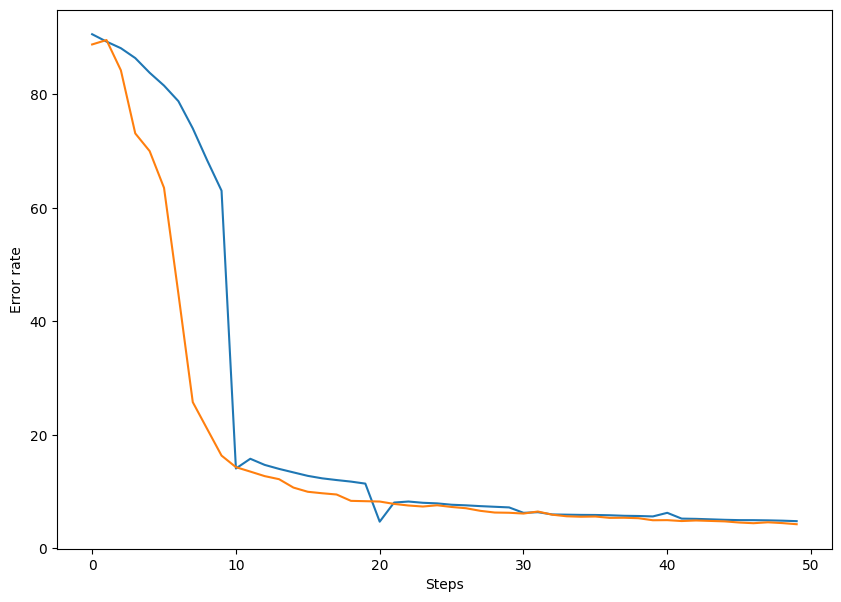

In [8]:
#绘制训练过程的误差曲线，校验集和测试集上的错误率。
plt.figure(figsize = (10, 7))
plt.plot(record) #record记载了每一个打印周期记录的训练和校验数据集上的准确度
plt.xlabel('Steps')
plt.ylabel('Error rate')

### 模型测试

In [9]:
net.eval()
vals = []
for data, target in test_loader:
    data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
    output = net(data)
    val = rightness(output, target)
    vals.append(val)

rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
print("测试集正确率为{}".format(right_rate))

测试集正确率为0.9760000109672546


### 剖析卷积神经网路

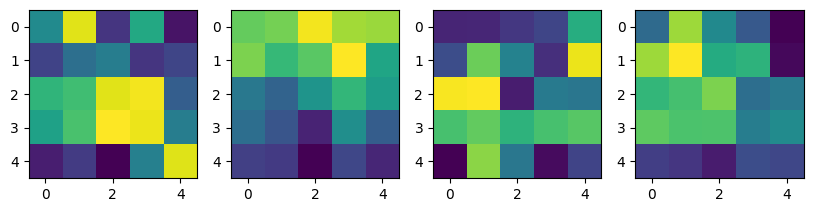

In [ ]:
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...]) # 选择第i个输出通道、第0个输入通道对应的卷积核

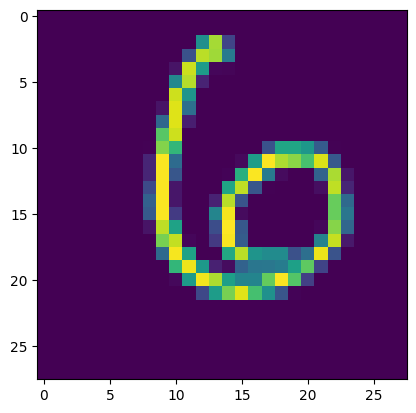

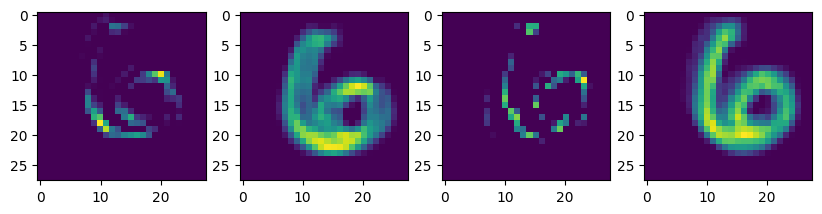

In [ ]:
input_x = test_dataset[idx][0].unsqueeze(0) # test_dataset[idx]包含特征和标签
feature_maps = net.retrieve_features(input_x)
plt.imshow(test_dataset[idx][0][0].numpy())

plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(feature_maps[0][0, i, ...].data.numpy()) # 打印第一层卷积层的第0批第i个通道的特征图

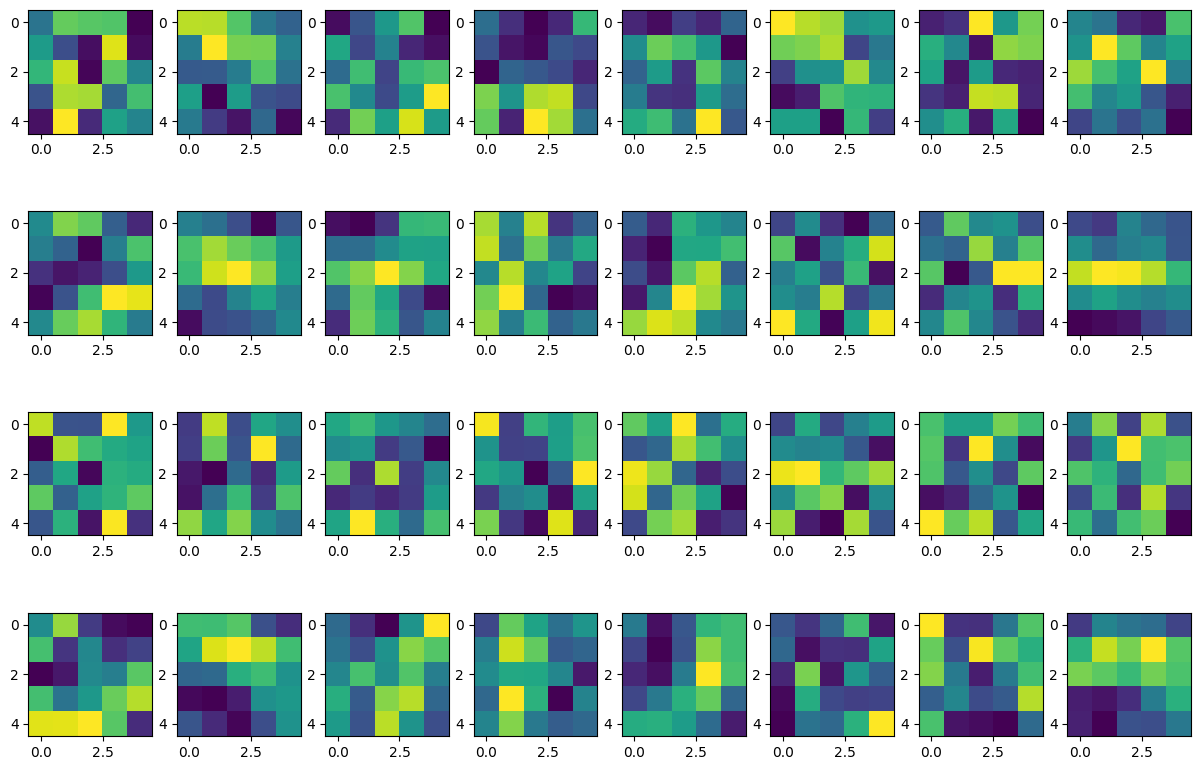

In [23]:
plt.figure(figsize=(15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.imshow(net.conv2.weight.data.numpy()[j, i, ...])

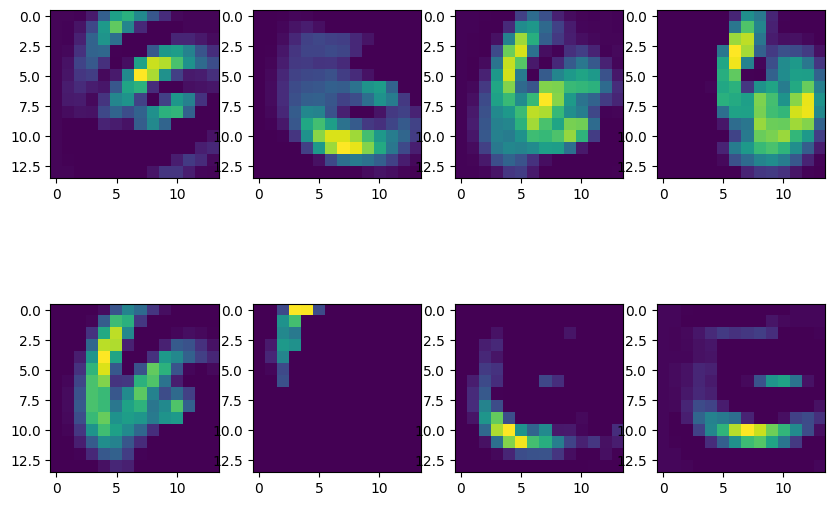

In [24]:
plt.figure(figsize=(10, 7))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(feature_maps[1][0, i, ...].data.numpy())

抽象程度更高了，证明了多层卷积神经网络的抽象提取能力

### 鲁棒性实验

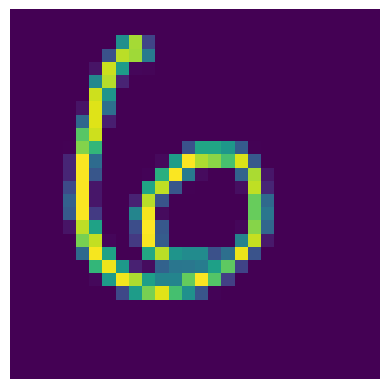

In [51]:
# 提取中test_dataset中的第idx个批次的第0个图的第0个通道对应的图像，定义为a。
a = test_dataset[idx][0][0]

# 平移后的新图像将放到b中。根据a给b赋值。
b = torch.zeros(a.size()) #全0的28*28的矩阵
w = 4 #平移的长度为4个像素

# 对于b中的任意像素i,j，它等于a中的i,j+w这个位置的像素
for i in range(a.size()[0]):
    for j in range(0, a.size()[1] - w):
        b[i, j] = a[i, j + w]

# 将b画出来
muteimg = b.numpy()
plt.axis('off')
plt.imshow(muteimg)

模型预测结果为[6]


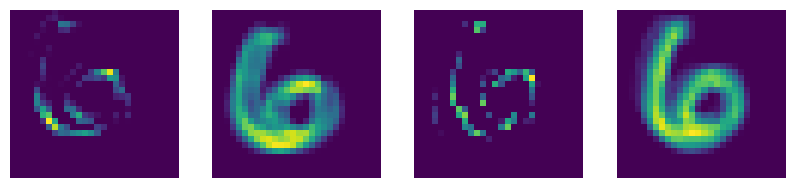

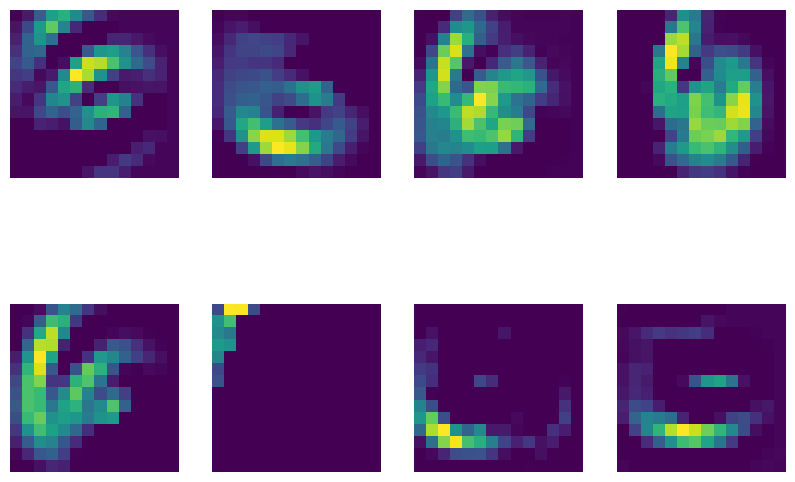

In [52]:
prediction = net(b.unsqueeze(0).unsqueeze(0))
pred = torch.max(prediction.data, 1)[1]
print("模型预测结果为{}".format(pred.data.numpy()))

#提取b对应的featuremap结果
feature_maps = net.retrieve_features(b.unsqueeze(0).unsqueeze(0))

plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')

    plt.imshow(feature_maps[1][0, i,...].data.numpy())

可以看出，局部的小变化不会引起高层特征图的更大变化，因此CNN具有很强的鲁棒性